Related urls, will remove once finished:
- https://www.tensorflow.org/tutorials/structured_data/time_series#multi-step_models

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import itertools

2024-03-07 21:38:38.187718: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-07 21:38:38.243034: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-07 21:38:38.243078: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-07 21:38:38.244591: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-07 21:38:38.252939: I tensorflow/core/platform/cpu_feature_guar

In [2]:
file_path = "../data/parsed_dataset.csv"
date_column = "Date"
target_column = "Close"
df = pd.read_csv(file_path, parse_dates=True)

df.set_index(date_column, inplace=True)
df = df.dropna()
dates = df.index.values

In [3]:
# Creating a data structure (it does not work when you have only one feature)
def create_data(
    df, n_future, n_past, train_test_split_percentage, validation_split_percentage
):
    n_feature = df.shape[1]
    x_data, y_data = [], []

    for i in range(n_past, len(df) - n_future + 1):
        x_data.append(df[i - n_past : i, 0:n_feature])
        y_data.append(df[i + n_future - 1 : i + n_future, 0])

    split_training_test_starting_point = int(
        round(train_test_split_percentage * len(x_data))
    )
    split_train_validation_starting_point = int(
        round(split_training_test_starting_point * (1 - validation_split_percentage))
    )

    x_train = x_data[:split_train_validation_starting_point]
    y_train = y_data[:split_train_validation_starting_point]

    # if you want to choose the validation set by yourself, uncomment the below code.
    x_val = x_data[
        split_train_validation_starting_point:split_training_test_starting_point
    ]
    y_val = x_data[
        split_train_validation_starting_point:split_training_test_starting_point
    ]

    x_test = x_data[split_training_test_starting_point:]
    y_test = y_data[split_training_test_starting_point:]

    return (
        np.array(x_train),
        np.array(x_test),
        np.array(x_val),
        np.array(y_train),
        np.array(y_test),
        np.array(y_val),
    )

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
scaled_data.shape

(3419, 8)

In [5]:
# Number of days you want to predict into the future
# Number of past days you want to use to predict the future

X_train, X_test, X_val, y_train, y_test, y_val = create_data(
    scaled_data,
    n_future=1,
    n_past=30,
    train_test_split_percentage=0.9,
    validation_split_percentage=0,
)

In [6]:
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(3050, 30, 8)
(339, 30, 8)
(3050, 1)
(339, 1)


In [7]:
# ------------------LSTM-----------------------
regressor = Sequential()
regressor.add(
    LSTM(
        units=16,
        return_sequences=True,
        input_shape=(X_train.shape[1], X_train.shape[2]),
    )
)
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=16, return_sequences=False))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1, activation="linear"))
regressor.compile(
    optimizer=tf.keras.optimizers.Adam(), loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 16)            1600      
                                                                 
 dropout (Dropout)           (None, 30, 16)            0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 3729 (14.57 KB)
Trainable params: 3729 (14.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)
# mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# fit model
history = regressor.fit(
    X_train, y_train, validation_split=0.3, epochs=200, batch_size=64, callbacks=[es]
)

Epoch 1/200
34/34 [==============================] - 4s 38ms/step - loss: 0.0890 - root_mean_squared_error: 0.2984 - val_loss: 1.5387 - val_root_mean_squared_error: 1.2405
Epoch 2/200
34/34 [==============================] - 1s 18ms/step - loss: 0.0239 - root_mean_squared_error: 0.1544 - val_loss: 1.4253 - val_root_mean_squared_error: 1.1938
Epoch 3/200
34/34 [==============================] - 1s 19ms/step - loss: 0.0156 - root_mean_squared_error: 0.1247 - val_loss: 1.3775 - val_root_mean_squared_error: 1.1737
Epoch 4/200
34/34 [==============================] - 1s 20ms/step - loss: 0.0133 - root_mean_squared_error: 0.1155 - val_loss: 1.3641 - val_root_mean_squared_error: 1.1680
Epoch 5/200
34/34 [==============================] - 1s 19ms/step - loss: 0.0126 - root_mean_squared_error: 0.1125 - val_loss: 1.3700 - val_root_mean_squared_error: 1.1705
Epoch 6/200
34/34 [==============================] - 1s 22ms/step - loss: 0.0114 - root_mean_squared_error: 0.1067 - val_loss: 1.3680 - val_

In [9]:
history.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

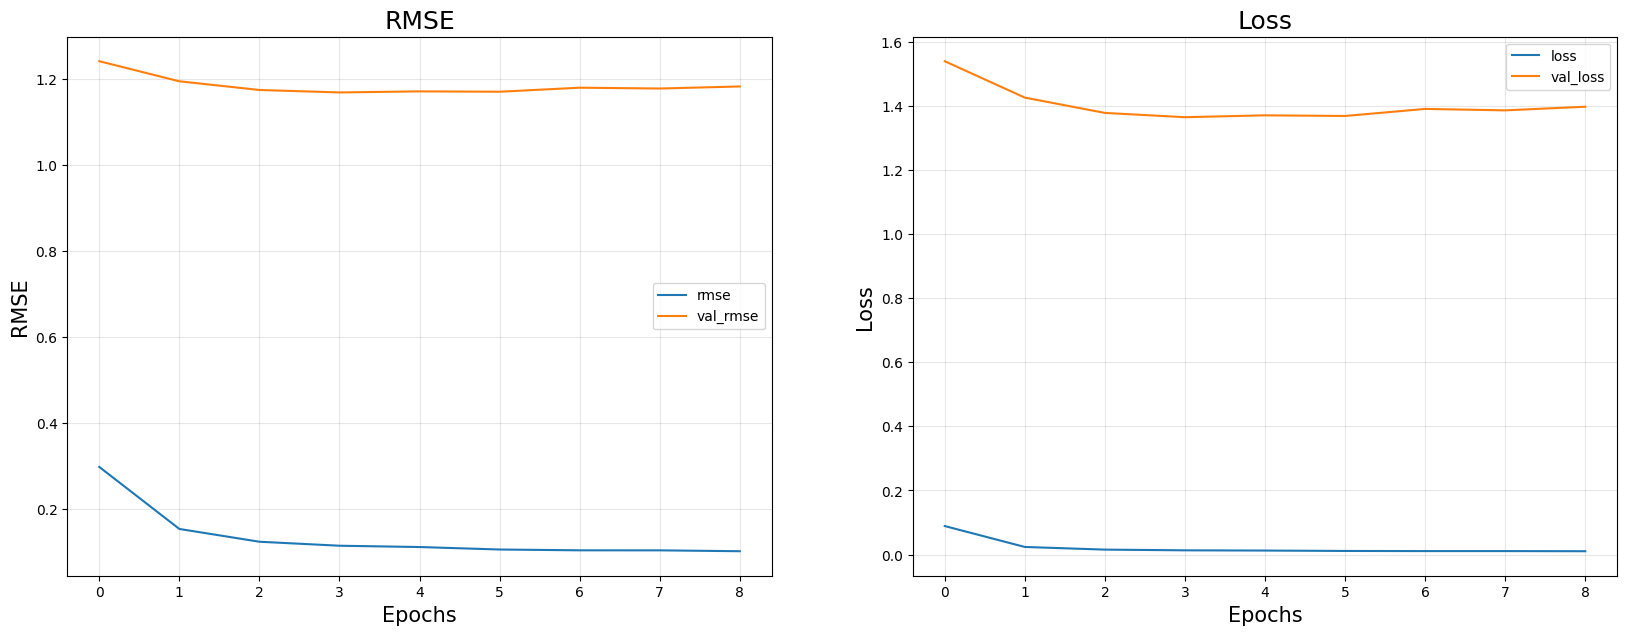

In [10]:
fig = plt.figure(figsize=(20, 7))
fig.add_subplot(121)

# Accuracy
plt.plot(history.epoch, history.history["root_mean_squared_error"], label="rmse")
plt.plot(
    history.epoch, history.history["val_root_mean_squared_error"], label="val_rmse"
)

plt.title("RMSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()


# Adding Subplot 1 (For Loss)
fig.add_subplot(122)

plt.plot(history.epoch, history.history["loss"], label="loss")
plt.plot(history.epoch, history.history["val_loss"], label="val_loss")

plt.title("Loss", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

In [11]:
results = regressor.evaluate(X_test, y_test)
print("test loss, test acc:", np.round(results, 4))

11/11 [==============================] - 0s 4ms/step - loss: 0.5731 - root_mean_squared_error: 0.7570
test loss, test acc: [0.5731 0.757 ]


In [12]:
# detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)


def LSTM_HyperParameter_Tuning(config, x_train, y_train, x_test, y_test):
    (
        first_additional_layer,
        second_additional_layer,
        third_additional_layer,
        n_neurons,
        n_batch_size,
        dropout,
    ) = config
    possible_combinations = list(
        itertools.product(
            first_additional_layer,
            second_additional_layer,
            third_additional_layer,
            n_neurons,
            n_batch_size,
            dropout,
        )
    )

    print(possible_combinations)
    print("\n")

    hist = []

    for i in range(0, len(possible_combinations)):
        print(f"{i+1}th combination: \n")
        print("--------------------------------------------------------------------")

        (
            first_additional_layer,
            second_additional_layer,
            third_additional_layer,
            n_neurons,
            n_batch_size,
            dropout,
        ) = possible_combinations[i]

        # instantiating the model in the strategy scope creates the model on the TPU
        # with tpu_strategy.scope():
        regressor = Sequential()
        regressor.add(
            LSTM(
                units=n_neurons,
                return_sequences=True,
                input_shape=(x_train.shape[1], x_train.shape[2]),
            )
        )
        regressor.add(Dropout(dropout))

        if first_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if second_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if third_additional_layer:
            regressor.add(GRU(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        regressor.add(LSTM(units=n_neurons, return_sequences=False))
        regressor.add(Dropout(dropout))
        regressor.add(Dense(units=1, activation="linear"))
        regressor.compile(
            optimizer=tf.keras.optimizers.Adam(),
            loss="mse",
            metrics=[tf.keras.metrics.RootMeanSquaredError()],
        )

        es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)
        """''
        From the mentioned article above --> If a validation dataset is specified to the fit() function via the validation_data or v
        alidation_split arguments,then the loss on the validation dataset will be made available via the name “val_loss.”
        """ ""

        file_path = "best_model.h5"

        mc = ModelCheckpoint(
            file_path, monitor="val_loss", mode="min", verbose=1, save_best_only=True
        )

        """''
        cb = Callback(...)  # First, callbacks must be instantiated.
        cb_list = [cb, ...]  # Then, one or more callbacks that you intend to use must be added to a Python list.
        model.fit(..., callbacks=cb_list)  # Finally, the list of callbacks is provided to the callback argument when fitting the model.
        """ ""

        regressor.fit(
            x_train,
            y_train,
            validation_split=0.3,
            epochs=1000,
            batch_size=n_batch_size,
            callbacks=[es, mc],
            verbose=0,
        )

        # load the best model
        # regressor = load_model('best_model.h5')

        train_accuracy = regressor.evaluate(x_train, y_train, verbose=0)
        test_accuracy = regressor.evaluate(x_test, y_test, verbose=0)

        hist.append(
            list(
                (
                    first_additional_layer,
                    second_additional_layer,
                    third_additional_layer,
                    n_neurons,
                    n_batch_size,
                    dropout,
                    train_accuracy,
                    test_accuracy,
                )
            )
        )

        print(
            f"{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}"
        )

    return hist

In [14]:
config = [
    [True, False],
    [True, False],
    [True, False],
    [64, 128, 256],
    [7, 28,365],
    [0.2],
]

# list of lists --> [[first_additional_layer], [second_additional_layer], [third_additional_layer], [n_neurons], [n_batch_size], [dropout]]

hist = LSTM_HyperParameter_Tuning(
    config, X_train, y_train, X_test, y_test
)  # change x_train shape

[(True, True, True, 64, 7, 0.2), (True, True, True, 64, 28, 0.2), (True, True, True, 64, 365, 0.2), (True, True, True, 128, 7, 0.2), (True, True, True, 128, 28, 0.2), (True, True, True, 128, 365, 0.2), (True, True, True, 256, 7, 0.2), (True, True, True, 256, 28, 0.2), (True, True, True, 256, 365, 0.2), (True, True, False, 64, 7, 0.2), (True, True, False, 64, 28, 0.2), (True, True, False, 64, 365, 0.2), (True, True, False, 128, 7, 0.2), (True, True, False, 128, 28, 0.2), (True, True, False, 128, 365, 0.2), (True, True, False, 256, 7, 0.2), (True, True, False, 256, 28, 0.2), (True, True, False, 256, 365, 0.2), (True, False, True, 64, 7, 0.2), (True, False, True, 64, 28, 0.2), (True, False, True, 64, 365, 0.2), (True, False, True, 128, 7, 0.2), (True, False, True, 128, 28, 0.2), (True, False, True, 128, 365, 0.2), (True, False, True, 256, 7, 0.2), (True, False, True, 256, 28, 0.2), (True, False, True, 256, 365, 0.2), (True, False, False, 64, 7, 0.2), (True, False, False, 64, 28, 0.2), (Tr

In [15]:
hist = pd.DataFrame(hist)
hist = hist.sort_values(by=[7], ascending=True)
hist

,0,1,2,3,4,5,6,7
71,False,False,False,256,365,0.2,"[0.021019957959651947, 0.14498260617256165]","[0.01423445250838995, 0.1193082258105278]"
16,True,True,False,256,28,0.2,"[0.03437817096710205, 0.18541350960731506]","[0.028751766309142113, 0.16956345736980438]"
37,False,True,True,64,28,0.2,"[0.07165536284446716, 0.267685204744339]","[0.029705272987484932, 0.17235217988491058]"
39,False,True,True,128,7,0.2,"[0.0691140741109848, 0.2628955543041229]","[0.03222893550992012, 0.17952419817447662]"
69,False,False,False,256,7,0.2,"[0.02809431217610836, 0.16761358082294464]","[0.03337107598781586, 0.1826775223016739]"
...,...,...,...,...,...,...,...,...
55,False,False,True,64,28,0.2,"[0.4987642467021942, 0.7062324285507202]","[0.7457513213157654, 0.8635689616203308]"
40,False,True,True,128,28,0.2,"[0.4601514935493469, 0.6783446669578552]","[0.7503319382667542, 0.8662170171737671]"
1,True,True,True,64,28,0.2,"[0.47152063250541687, 0.6866735816001892]","[0.8253831267356873, 0.9085059762001038]"
7,True,True,True,256,28,0.2,"[0.5525166392326355, 0.7433146238327026]","[0.8540832996368408, 0.9241662621498108]"


In [16]:
print(
    f"Best Combination: \n first_additional_layer = {hist.iloc[0, 0]}\n second_additional_layer = {hist.iloc[0, 1]}\n third_additional_layer = {hist.iloc[0, 2]}\n n_neurons = {hist.iloc[0, 3]}\n n_batch_size = {hist.iloc[0, 4]}\n dropout = {hist.iloc[0, 5]}"
)
print("**************************")
print(f"Results Before Tunning:\n Test Set RMSE: {np.round(results, 4)[1]}\n")
print(f"Results After Tunning:\n Test Set RMSE: {np.round(hist.iloc[0, -1], 4)[1]}\n")
print(
    f"{np.round((results[1] - hist.iloc[0, -1][1])*100/np.round(results, 4)[1])}% Improvement"
)

Best Combination: 
 first_additional_layer = False
 second_additional_layer = False
 third_additional_layer = False
 n_neurons = 256
 n_batch_size = 365
 dropout = 0.2
**************************
Results Before Tunning:
 Test Set RMSE: 0.757

Results After Tunning:
 Test Set RMSE: 0.1193

84.0% Improvement


In [17]:
(
    first_additional_layer,
    second_additional_layer,
    third_additional_layer,
    n_neurons,
    n_batch_size,
    dropout,
) = list(hist.iloc[0, :-2])

In [18]:
regressor = Sequential()
regressor.add(
    LSTM(
        units=n_neurons,
        return_sequences=True,
        input_shape=(X_train.shape[1], X_train.shape[2]),
    )
)
regressor.add(Dropout(dropout))

if first_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if second_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if third_additional_layer:
    regressor.add(GRU(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

regressor.add(LSTM(units=n_neurons, return_sequences=False))
regressor.add(Dropout(dropout))
regressor.add(Dense(units=1, activation="linear"))
regressor.compile(optimizer=tf.keras.optimizers.Adam(), loss="mse")

es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)

file_path = "best_model.h5"

mc = ModelCheckpoint(
    file_path, monitor="val_loss", mode="min", verbose=1, save_best_only=True
)

regressor.fit(
    X_train,
    y_train,
    validation_split=0.3,
    epochs=200,
    batch_size=n_batch_size,
    callbacks=[es, mc],
    verbose=0,
)


Epoch 1: val_loss improved from inf to 0.27475, saving model to best_model.h5


/home/samuell/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.27475 to 0.09043, saving model to best_model.h5

Epoch 3: val_loss improved from 0.09043 to 0.06777, saving model to best_model.h5

Epoch 4: val_loss improved from 0.06777 to 0.05668, saving model to best_model.h5

Epoch 5: val_loss did not improve from 0.05668

Epoch 6: val_loss did not improve from 0.05668

Epoch 7: val_loss did not improve from 0.05668

Epoch 8: val_loss did not improve from 0.05668

Epoch 9: val_loss did not improve from 0.05668
Epoch 9: early stopping


In [19]:
regressor.evaluate(X_test, y_test)

11/11 [==============================] - 0s 28ms/step - loss: 0.0200


0.02003570646047592

In [20]:
y_pred = regressor.predict(X_test)

11/11 [==============================] - 1s 21ms/step


11/11 [==============================] - 0s 24ms/step


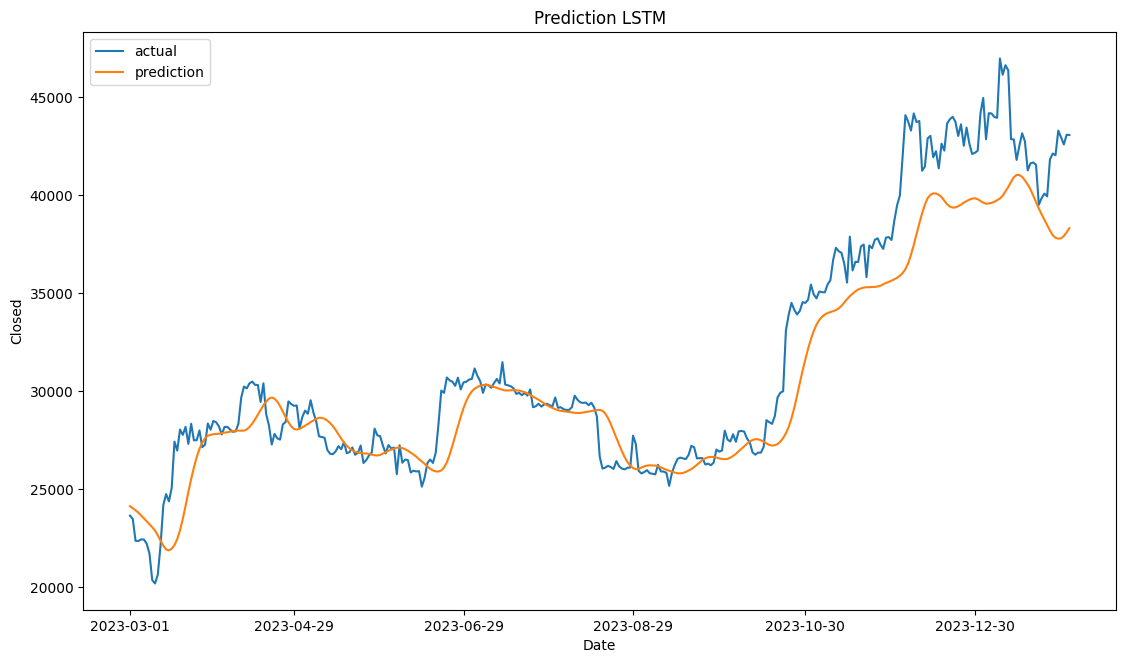

In [21]:
scaler = StandardScaler()
scaler.fit(df[[target_column]])
y_pred = regressor.predict(X_test)
unscaled_y_pred = scaler.inverse_transform([y_pred.flatten()])[0]
unscaled_y_test = scaler.inverse_transform([y_test.flatten()])[0]

import matplotlib.dates as mdates
data_length = len(unscaled_y_test)

fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(dates[-data_length:], unscaled_y_test, label="actual")
ax.plot(dates[-data_length:], unscaled_y_pred, label="prediction")
ax.set_title("Prediction LSTM")
ax.set_ylabel("Closed")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

In [22]:
from metrics import print_evaluation_metrics
print_evaluation_metrics(unscaled_y_pred, unscaled_y_test)


Evaluation Metrics:
MSE: 5355620.63
RMSE: 2314.22
MAE: 1642.34
MAPE: 4.84
SMAPE: 5.01
